In [0]:
import tensorflow as tf
#import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [0]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, ReLU, LeakyReLU, Dropout,Input
from tensorflow.keras.optimizers import Adam, RMSprop
import random
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Activation
from tensorflow.keras.initializers import RandomNormal



In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

## Preprocessing

X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape+ (1,))

# Normalizer dtype

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = 2*(X_train/255.0)-1
X_test = 2*(X_test/255.0)-1

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# X_train[0].shape

In [0]:
# So chieu cua noise vector input ban dau
z_dim = 100

In [0]:
# Optimizer

adam = Adam(learning_rate = 0.0002, beta_1 = 0.5)

In [8]:
# Generator Model
g = Sequential()
init = RandomNormal(stddev=0.02)

g.add(Dense(units = 7*7*256, input_dim = z_dim, kernel_initializer=init))
# 7*7*256
g.add(Reshape((7,7,256)))
g.add(BatchNormalization())
g.add(Activation('relu'))
# 7*7*128
g.add(Conv2DTranspose(128, kernel_size=(3,3), 
                      strides=1, padding='same',kernel_initializer=init))
g.add(BatchNormalization())
g.add(Activation('relu'))
# 14*14*64
g.add(Conv2DTranspose(64, kernel_size=(3,3), 
                      strides=2, padding='same',kernel_initializer=init))
g.add(BatchNormalization())
g.add(Activation('relu'))
# 28*28*1
g.add(Conv2DTranspose(1, kernel_size=(3,3), 
                      strides=2, padding='same',kernel_initializer=init))
g.add(BatchNormalization())
g.add(Activation('tanh'))

g.compile(loss = 'binary_crossentropy', optimizer = adam, 
          metrics = ['accuracy'])

g.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1266944   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 256)         1024      
_________________________________________________________________
activation (Activation)      (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         295040    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 128)         0

In [9]:
## Discriminator Model

d = Sequential()
# 14*14*64
d.add(Conv2D(64, input_shape = (28,28,1),
             kernel_size = (3,3), strides = 2, padding = 'same'))
d.add(BatchNormalization())
d.add(LeakyReLU(0.2))

#7*7*128
d.add(Conv2D(128, kernel_size = (3,3), 
             strides = 2, padding = 'same'))
d.add(BatchNormalization())
d.add(LeakyReLU(0.2))
d.add(Dropout(0.25))

#6272
d.add(Flatten())
d.add(Dense(1, activation = 'sigmoid'))

d.compile(loss= 'binary_crossentropy', 
          optimizer = adam,
          metrics = ['accuracy'])

d.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 128)        

In [10]:
d.trainable = False

inputs = Input(shape = (z_dim, ))

g_output = g(inputs)
output = d(g_output)

gan = Model(inputs, output)
gan.compile(loss = 'binary_crossentropy', 
            optimizer = adam, 
            metrics = ['accuracy'])

gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         1638149   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 81537     
Total params: 1,719,686
Trainable params: 1,637,251
Non-trainable params: 82,435
_________________________________________________________________


In [0]:
# Draw loss function
def plot_loss(losses):
    d_loss = [v[0] for v in losses['D']]
    g_loss = [v[0] for v in losses['G']]

    # plt.figure(fig_size = (10,10))
    plt.plot(d_loss, label = 'Disc. Loss')
    plt.plot(g_loss, label = 'Gen. Loss') 

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Draw sample from Generator
def plot_generated(n_ex = 10, dim = (1,10), figsize= (8,4)):
    noise = np.random.normal(0,1,size= (n_ex, z_dim))
    generated_image = g.predict(noise)
    generated_image = generated_image.reshape(n_ex, 28, 28)

    plt.figure()
    for i in range(generated_image.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_image[i],
                   interpolation='nearest',
                   cmap = 'gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
        

In [0]:
# Save loss and accuracy values

losses = {'D': [], 'G': []}

In [0]:
from tqdm import tqdm_notebook as notebook

In [0]:
def train(epochs = 1, plt_frq = 1, BATCH_SIZE = 128):
    batchCount = int(X_train.shape[0]/ BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    for e in notebook(range(1, epochs + 1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, "Epoch %d" % e, '-'*15)
        for _ in range(batchCount):
            # Lay ngau nhien anh tu MNIST dataset (real)
            image_batch = X_train[np.random.randint(0,X_train.shape[0], size = BATCH_SIZE)]
            # Noise random vector input
            noise = np.random.normal(0,1,size = (BATCH_SIZE, z_dim))
            # Generator sinh ra tu and noise
            generated_images = g.predict(noise)
            
            X = np.concatenate((image_batch, generated_images))
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9

            # Train Discriminator
            d.trainable = True
            d_loss = d.train_on_batch(X,y)

            # Train Generator
            noise = np.random.normal(0,1,size = (BATCH_SIZE, z_dim))
            ## Khi train generator gan label bang 1 de lua Discriminator
            y2 = np.ones(BATCH_SIZE)
            ## Khi train generator khong cap nhat he so cua Disciminator
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)
        
        #Save loss function
        losses['D'].append(d_loss)
        losses['G'].append(g_loss)

        # Vẽ các số được sinh ra để kiểm tra kết quả
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

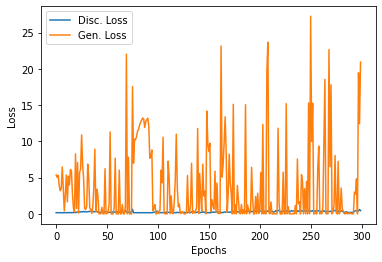

In [19]:
plot_loss(losses)

Epochs: 300
Batch size: 128
Batches per epoch: 468


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


--------------- Epoch 1 ---------------


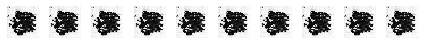

--------------- Epoch 20 ---------------


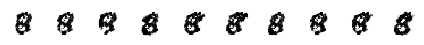

--------------- Epoch 40 ---------------


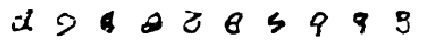

--------------- Epoch 60 ---------------


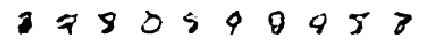

--------------- Epoch 80 ---------------


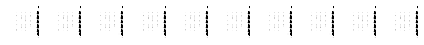

--------------- Epoch 100 ---------------


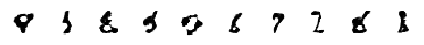

--------------- Epoch 120 ---------------


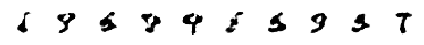

--------------- Epoch 140 ---------------


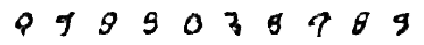

--------------- Epoch 160 ---------------


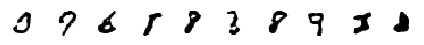

--------------- Epoch 180 ---------------


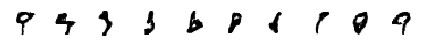

--------------- Epoch 200 ---------------


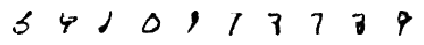

--------------- Epoch 220 ---------------


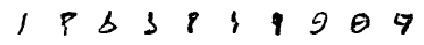

--------------- Epoch 240 ---------------


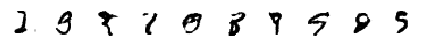

--------------- Epoch 260 ---------------


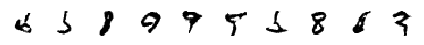

--------------- Epoch 280 ---------------


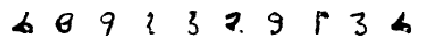

--------------- Epoch 300 ---------------


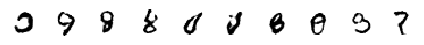

TypeError: ignored

In [15]:
train(epochs=300, plt_frq=20, BATCH_SIZE=128)